In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Capacitor parameters
capacitor_value = 10000e-6  # Farads (200 μF)
capacitor_voltage = 19  # Volts
capacitor_esr = 15e-3  # Ohms (15 mΩ)

# Coil parameters
coil_inductance = 0.063e-3  # Henries (0.6 mH)
coil_resistance = 0.144  # Ohms
coil_length = 20e-3  # meters (25 mm)
coil_internal_diameter = 6e-3  # meters (8 mm)
coil_external_diameter = 17e-3  # meters (17 mm)
number_of_turns = 156  # turns

# Projectile parameters
# Relative permeabilities (μr):
# Iron: ~4000
# Steel: ~100-1000
# Nickel: ~100
# Cobalt: ~250
# Ferrite: ~1000-3000
# Mu-metal: ~100,000
projectile_rel_permeability = 4000  # Iron (dimensionless)
projectile_mass = 3.7e-3  # kg (3.7 g)
projectile_length = 25e-3  # meters (25 mm)
projectile_diameter = 5e-3  # meters (5 mm)

# System parameters
number_of_stages = 4  # stages
stage_effectiveness = 0.13  # 5% efficiency per stage
initial_velocity = 0.1  # m/s

# Calculate derived parameters
coil_mean_radius = (coil_internal_diameter + coil_external_diameter) / 4  # meters
coil_cross_section = ((coil_external_diameter - coil_internal_diameter) / 2) * coil_length  # m²
projectile_volume = np.pi * (projectile_diameter/2)**2 * projectile_length  # m³
projectile_cross_section = np.pi * (projectile_diameter/2)**2  # m²

coupling_factor = projectile_cross_section / (coil_cross_section)

# Display parameters in a nice format
print("Reluctance Mass Accelerator Parameters:")
print("-" * 40)
print(f"Capacitor: {capacitor_value*1e6:.1f} μF at {capacitor_voltage:.0f} V (ESR: {capacitor_esr*1e3:.1f} mΩ)")
print(f"Coil: {coil_inductance*1e3:.3f} mH, {coil_resistance:.3f} Ω, {number_of_turns} turns")
print(f"Coil dimensions: {coil_length*1e3:.1f} mm length, {coil_internal_diameter*1e3:.1f}-{coil_external_diameter*1e3:.1f} mm diameter")
print(f"Projectile: Iron (μr={projectile_rel_permeability}), {projectile_mass*1e3:.1f} g")
print(f"Projectile dimensions: {projectile_length*1e3:.1f} mm length, {projectile_diameter*1e3:.1f} mm diameter")
print(f"Coupling factor: {coupling_factor:.3f}")
print(f"System: {number_of_stages} stages, {stage_effectiveness*100:.1f}% effectiveness per stage")

# Calculate capacitor energy
capacitor_energy = 0.5 * capacitor_value * capacitor_voltage**2
print(f"\nCapacitor energy: {capacitor_energy:.2f} J")

# Cell 2: Capacitor Discharge and Current Calculation
# =================================================

# Calculate characteristic parameters of the RLC circuit
total_resistance = capacitor_esr + coil_resistance  # Ohms
total_inductance = coil_inductance  # Henries
time_constant = 2 * total_inductance / total_resistance  # seconds
resonant_frequency = 1 / (2 * np.pi * np.sqrt(total_inductance * capacitor_value))  # Hz
damping_factor = total_resistance / (2 * np.sqrt(total_inductance / capacitor_value))

def current_at_time(t):
    """Calculate the current in the RLC circuit at time t."""
    # For an underdamped RLC circuit (typical case for a coilgun)
    if damping_factor < 1:
        omega_d = np.sqrt((1/(total_inductance*capacitor_value)) - (total_resistance/(2*total_inductance))**2)
        return capacitor_voltage * np.exp(-t*total_resistance/(2*total_inductance)) * np.sin(omega_d*t) / (omega_d*total_inductance)
    # For critically damped case
    elif damping_factor == 1:
        return (capacitor_voltage / total_inductance) * t * np.exp(-total_resistance*t/(2*total_inductance))
    # For overdamped case
    else:
        s1 = -total_resistance/(2*total_inductance) + np.sqrt((total_resistance/(2*total_inductance))**2 - 1/(total_inductance*capacitor_value))
        s2 = -total_resistance/(2*total_inductance) - np.sqrt((total_resistance/(2*total_inductance))**2 - 1/(total_inductance*capacitor_value))
        return capacitor_voltage * (np.exp(s1*t) - np.exp(s2*t)) / (total_inductance * (s1 - s2))
    
# Calculate discharge time (time to 95% energy discharge)
discharge_time = 3 * time_constant  # approximation
resonant_time = 0.5/resonant_frequency
print(f"Resonant time constant: {resonant_time*1e6:.2f} μs")
print(f"Discharge time constant: {time_constant*1e6:.2f} μs")
print(f"Estimated discharge time (95%): {discharge_time*1e6:.2f} μs")

# Calculate the time of peak current
if damping_factor < 1:
    # For underdamped case
    peak_current_time = np.pi / (2 * np.sqrt(1/(total_inductance*capacitor_value) - (total_resistance/(2*total_inductance))**2))
else:
    # For critically damped or overdamped
    peak_current_time = total_inductance / total_resistance
    
peak_current = current_at_time(peak_current_time)
print(f"Peak current: {peak_current:.2f} A at {peak_current_time*1e6:.2f} μs")

# Projectile constraints calculation:
def constant_acceleration_max_time(E0, E):
    return 2 * coil_length / ((2*E0/projectile_mass)**.5 + (2*E/projectile_mass)**.5)

E0 = projectile_mass * initial_velocity**2 / 2
print("\n", [constant_acceleration_max_time(E0+capacitor_energy*stage_effectiveness*stage, E0+capacitor_energy*stage_effectiveness*(stage+1))*1000 for stage in range(number_of_stages)])
final_estimated_energy = E0+capacitor_energy*stage_effectiveness*number_of_stages
final_estimated_velocity = (2*final_estimated_energy / projectile_mass)**.5
print(f"Estimated final energy: {final_estimated_energy:.2f} J")
print(f"Estimated final velocity: {final_estimated_velocity:.2f} m/s")


Reluctance Mass Accelerator Parameters:
----------------------------------------
Capacitor: 10000.0 μF at 19 V (ESR: 15.0 mΩ)
Coil: 0.063 mH, 0.144 Ω, 156 turns
Coil dimensions: 20.0 mm length, 6.0-17.0 mm diameter
Projectile: Iron (μr=4000), 3.7 g
Projectile dimensions: 25.0 mm length, 5.0 mm diameter
Coupling factor: 0.178
System: 4 stages, 13.0% effectiveness per stage

Capacitor energy: 1.80 J
Resonant time constant: 2493.56 μs
Discharge time constant: 792.45 μs
Estimated discharge time (95%): 2377.36 μs
Peak current: 72.49 A at 396.23 μs

 [3.520297959105618, 1.47111893557342, 1.1288425601177476, 0.9516627854085328]
Estimated final energy: 0.94 J
Estimated final velocity: 22.52 m/s


In [127]:
def calculate_rcd_clamp(coil_inductance, capacitor_value, capacitor_voltage, maximum_voltage, maximum_current, firing_rate=None, fixed_clamp_capacitance=None):
    """
    Calculate RCD clamp values for SCR protection.
    
    Parameters:
    coil_inductance (float): Inductance of the coil in Henry
    capacitor_value (float): Value of the main capacitor in Farad
    capacitor_voltage (float): Initial voltage the capacitor is charged to in Volts
    maximum_voltage (float): Maximum allowed voltage on the SCR in Volts
    maximum_current (float): Maximum current the clamp diode can handle in Amperes
    firing_rate (float, optional): Rate at which the circuit fires in Hz
    fixed_clamp_capacitance (float, optional): Fixed clamp capacitance to use (in Farad)
    
    Returns:
    tuple: (clamp_capacitance, clamp_resistance, clamp_r_power, clamp_c_power, estimated_voltage_peak)
    """
    # Calculate peak current through the SCR when it's on
    # I = V * sqrt(C/L)
    peak_current = capacitor_voltage * (capacitor_value / coil_inductance)**.5
    
    # Calculate energy stored in the inductor at peak current
    # E = 0.5 * L * I²
    inductor_energy = 0.5 * coil_inductance * (peak_current ** 2)
    
    # If a fixed capacitance is provided, use it; otherwise calculate the recommended value
    if fixed_clamp_capacitance is not None:
        clamp_capacitance = fixed_clamp_capacitance
    else:
        # Calculate the clamp capacitance (typically 0.1 to 0.2 μF per ampere of peak current)
        clamp_capacitance = 0.15e-6 * peak_current  # 0.15 μF per ampere
        
        # Calculate the maximum energy that can be absorbed by the clamp capacitor
        # E = 0.5 * C * (Vmax² - Vinitial²)
        # Where Vinitial is typically 0 for an initially discharged clamp capacitor
        clamp_energy_capacity = 0.5 * clamp_capacitance * (maximum_voltage ** 2)
        
        # Ensure clamp capacitor can handle the inductor energy
        if clamp_energy_capacity < inductor_energy:
            # Adjust clamp capacitance if needed
            clamp_capacitance = 2 * inductor_energy / (maximum_voltage ** 2)
    
    # Estimate the peak voltage on the capacitor
    # V = sqrt(2*E/C)
    estimated_voltage_peak = (2 * inductor_energy / clamp_capacitance)**.5
    
    # Ensure the estimated peak voltage doesn't exceed maximum allowed voltage
    if estimated_voltage_peak > maximum_voltage:
        print(f"Warning: With {clamp_capacitance*1e6:.2f} μF capacitor, voltage may reach {estimated_voltage_peak:.2f} V, exceeding {maximum_voltage} V limit.")
    
    # Calculate the clamp resistance
    # R should be low enough to discharge the capacitor quickly but high enough to limit current
    clamp_resistance = maximum_voltage / maximum_current
    
    # Calculate the power rating required for the resistor
    # P = V²/R for the worst case scenario
    clamp_r_power = (maximum_voltage ** 2) / clamp_resistance
    
    # Calculate capacitor power rating if firing rate is provided
    clamp_c_power = None
    if firing_rate is not None:
        # Energy per cycle * firing rate = average power
        clamp_c_power = inductor_energy * firing_rate
    
    return clamp_capacitance, clamp_resistance, clamp_r_power, clamp_c_power, estimated_voltage_peak

def calculate_resistor_temp_rise(resistance, energy, thermal_mass=None):
    """
    Calculate the temperature rise of a resistor during a single energy discharge.
    
    Parameters:
    resistance (float): Resistance value in Ohms
    energy (float): Energy dissipated in the resistor in Joules
    thermal_mass (float, optional): Thermal mass of the resistor in J/°C
                                   If None, estimated based on resistor power rating
    
    Returns:
    float: Temperature rise in °C
    """
    # If thermal mass not provided, estimate based on typical values
    # A 20W resistor typically has thermal mass around 2-5 J/°C
    if thermal_mass is None:
        # Assuming a 20W resistor with thermal mass of 3.5 J/°C
        thermal_mass = 3.5  
    
    # Temperature rise = Energy / Thermal mass
    temp_rise = energy / thermal_mass
    
    return temp_rise

# Example usage with sample values
# Uncomment and replace with actual values when available
maximum_voltage = 1600    # 1600 V (max SCR voltage)
maximum_current = 1200      # 5 A
firing_rate = 0.5         # Hz
fixed_clamp_capacitance = 20e-6

clamp_capacitance, clamp_resistance, clamp_r_power, clamp_c_power, estimated_voltage_peak = calculate_rcd_clamp(
    coil_inductance, capacitor_value, capacitor_voltage, maximum_voltage, maximum_current, firing_rate, fixed_clamp_capacitance=fixed_clamp_capacitance
)

# Calculate peak current and inductor energy for temperature rise calculation
peak_current = capacitor_voltage * (capacitor_value / coil_inductance)**.5
inductor_energy = 0.5 * coil_inductance * (peak_current ** 2)

# Calculate temperature rise of a 20W resistor during one shot
temp_rise = calculate_resistor_temp_rise(clamp_resistance, inductor_energy)

print(f"Peak Current: {peak_current:.2f} A")
print(f"Energy per shot: {inductor_energy:.4f} J")
print(f"Optimal Clamp Capacitance: {clamp_capacitance * 1e6:.2f} μF")
print(f"Estimated Peak Voltage: {estimated_voltage_peak:.2f} V")
print(f"Clamp Resistance: {clamp_resistance:.2f} Ω")
print(f"Clamp Resistor Power Rating: {clamp_r_power:.2f} W")
print(f"Clamp Capacitor Power Rating (at {firing_rate} Hz): {clamp_c_power:.4f} W")
print(f"Temperature Rise during one shot (20W resistor): {temp_rise:.2f} °C")

Peak Current: 239.38 A
Energy per shot: 1.8050 J
Optimal Clamp Capacitance: 20.00 μF
Estimated Peak Voltage: 424.85 V
Clamp Resistance: 1.33 Ω
Clamp Resistor Power Rating: 1920000.00 W
Clamp Capacitor Power Rating (at 0.5 Hz): 0.9025 W
Temperature Rise during one shot (20W resistor): 0.52 °C


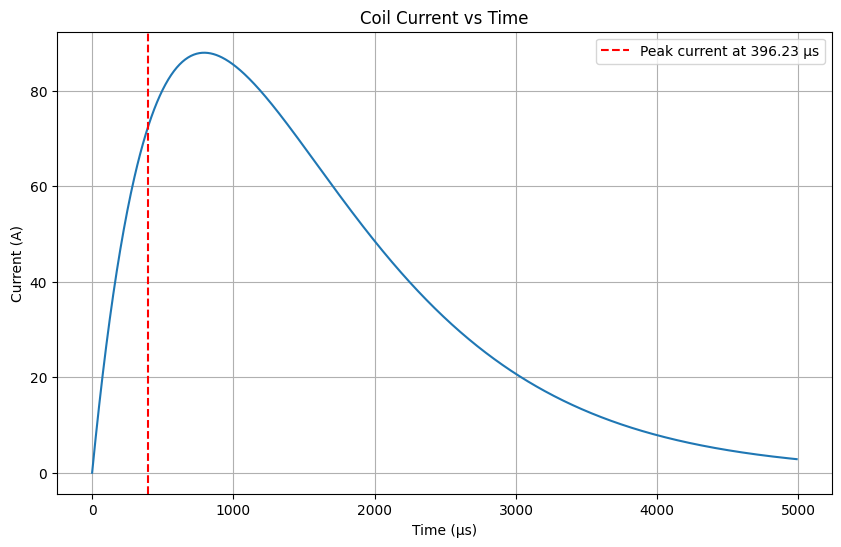

In [128]:
# Plot the current vs time
t_values = np.linspace(0, resonant_time * 2, 1000)
current_values = [current_at_time(t) for t in t_values]

plt.figure(figsize=(10, 6))
plt.plot(t_values * 1e6, current_values)  # Convert time to microseconds
plt.title('Coil Current vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Current (A)')
plt.grid(True)
plt.axvline(x=peak_current_time * 1e6, color='r', linestyle='--', label=f'Peak current at {peak_current_time*1e6:.2f} μs')
plt.legend()
plt.show()

Peak magnetic energy: 59.60 J at 172.12 μs
This represents 93.1% of the initial capacitor energy


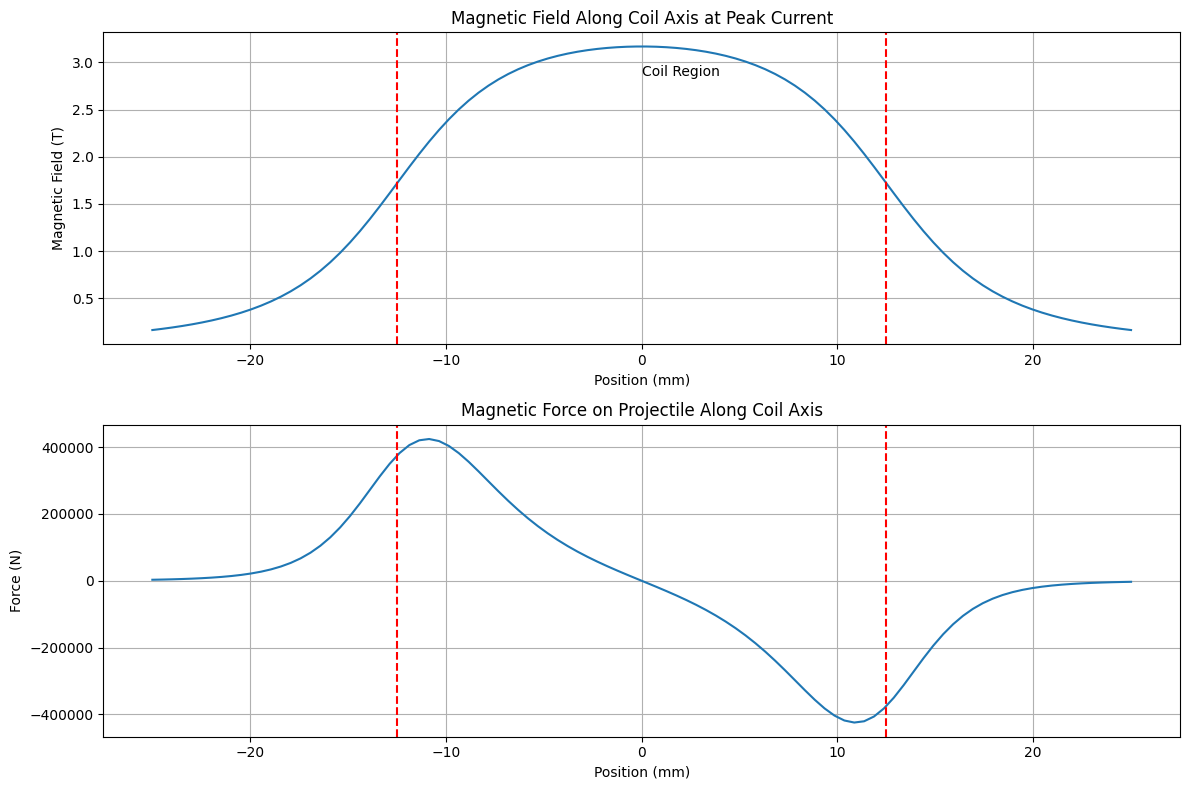

In [76]:
# Constants
mu0 = 4 * np.pi * 1e-7  # Vacuum permeability (H/m)

def magnetic_field_at_point(x, current):
    """
    Calculate the magnetic field strength at position x along the coil axis.
    
    Parameters:
    x (float): Position along the coil axis, with origin at coil center (m)
    current (float): Current through the coil (A)
    
    Returns:
    float: Magnetic field intensity (T)
    """
    # Using the simplified formula for magnetic field along the axis of a solenoid
    # B = μ0 * n * I * (coil_length / sqrt(coil_length^2 + 4*x^2))
    # where n is turns per unit length
    
    n = number_of_turns / coil_length  # turns per meter
    
    # Adjust x to be relative to both ends of the coil
    x1 = x - coil_length/2  # Distance from left edge
    x2 = x + coil_length/2  # Distance from right edge
    
    # Using the more accurate formula for finite solenoid
    # B = (μ0 * n * I / 2) * ((x2 / sqrt(r^2 + x2^2)) - (x1 / sqrt(r^2 + x1^2)))
    B = (mu0 * n * current / 2) * ((x2 / np.sqrt(coil_mean_radius**2 + x2**2)) - 
                                   (x1 / np.sqrt(coil_mean_radius**2 + x1**2)))
    
    return B

def magnetic_force_on_projectile(x, current):
    """
    Calculate the magnetic force on the projectile at position x.
    
    Parameters:
    x (float): Position of the projectile's center along the coil axis (m)
    current (float): Current through the coil (A)
    
    Returns:
    float: Force on the projectile (N)
    """
    # For a reluctance accelerator, force is related to the gradient of magnetic field
    # F = (μr-1) * V * B * dB/dx / (2*μ0)
    
    # Calculate field gradient using numerical approximation
    dx = 1e-5  # Small distance for derivative calculation
    B1 = magnetic_field_at_point(x - dx, current)
    B2 = magnetic_field_at_point(x + dx, current)
    dB_dx = (B2 - B1) / (2 * dx)
    
    # Get B at this point
    B = magnetic_field_at_point(x, current)
    
    # Calculate force
    force = (projectile_rel_permeability - 1) * projectile_volume * B * dB_dx / (2 * mu0)
    
    return force

# Calculate peak magnetic energy
peak_magnetic_energy = 0.5 * coil_inductance * peak_current**2
print(f"Peak magnetic energy: {peak_magnetic_energy:.2f} J at {peak_current_time*1e6:.2f} μs")
print(f"This represents {peak_magnetic_energy/capacitor_energy*100:.1f}% of the initial capacitor energy")

# Plot magnetic field along axis at peak current
x_positions = np.linspace(-coil_length, coil_length, 100)
field_values = [magnetic_field_at_point(x, peak_current) for x in x_positions]
force_values = [magnetic_force_on_projectile(x, peak_current) for x in x_positions]

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(x_positions * 1000, field_values)  # Convert to mm
plt.title('Magnetic Field Along Coil Axis at Peak Current')
plt.xlabel('Position (mm)')
plt.ylabel('Magnetic Field (T)')
plt.grid(True)
plt.axvline(x=-coil_length/2 * 1000, color='r', linestyle='--')
plt.axvline(x=coil_length/2 * 1000, color='r', linestyle='--')
plt.annotate('Coil Region', xy=(0, max(field_values)*0.9))

plt.subplot(2, 1, 2)
plt.plot(x_positions * 1000, force_values)  # Convert to mm
plt.title('Magnetic Force on Projectile Along Coil Axis')
plt.xlabel('Position (mm)')
plt.ylabel('Force (N)')
plt.grid(True)
plt.axvline(x=-coil_length/2 * 1000, color='r', linestyle='--')
plt.axvline(x=coil_length/2 * 1000, color='r', linestyle='--')

plt.tight_layout()
plt.show()

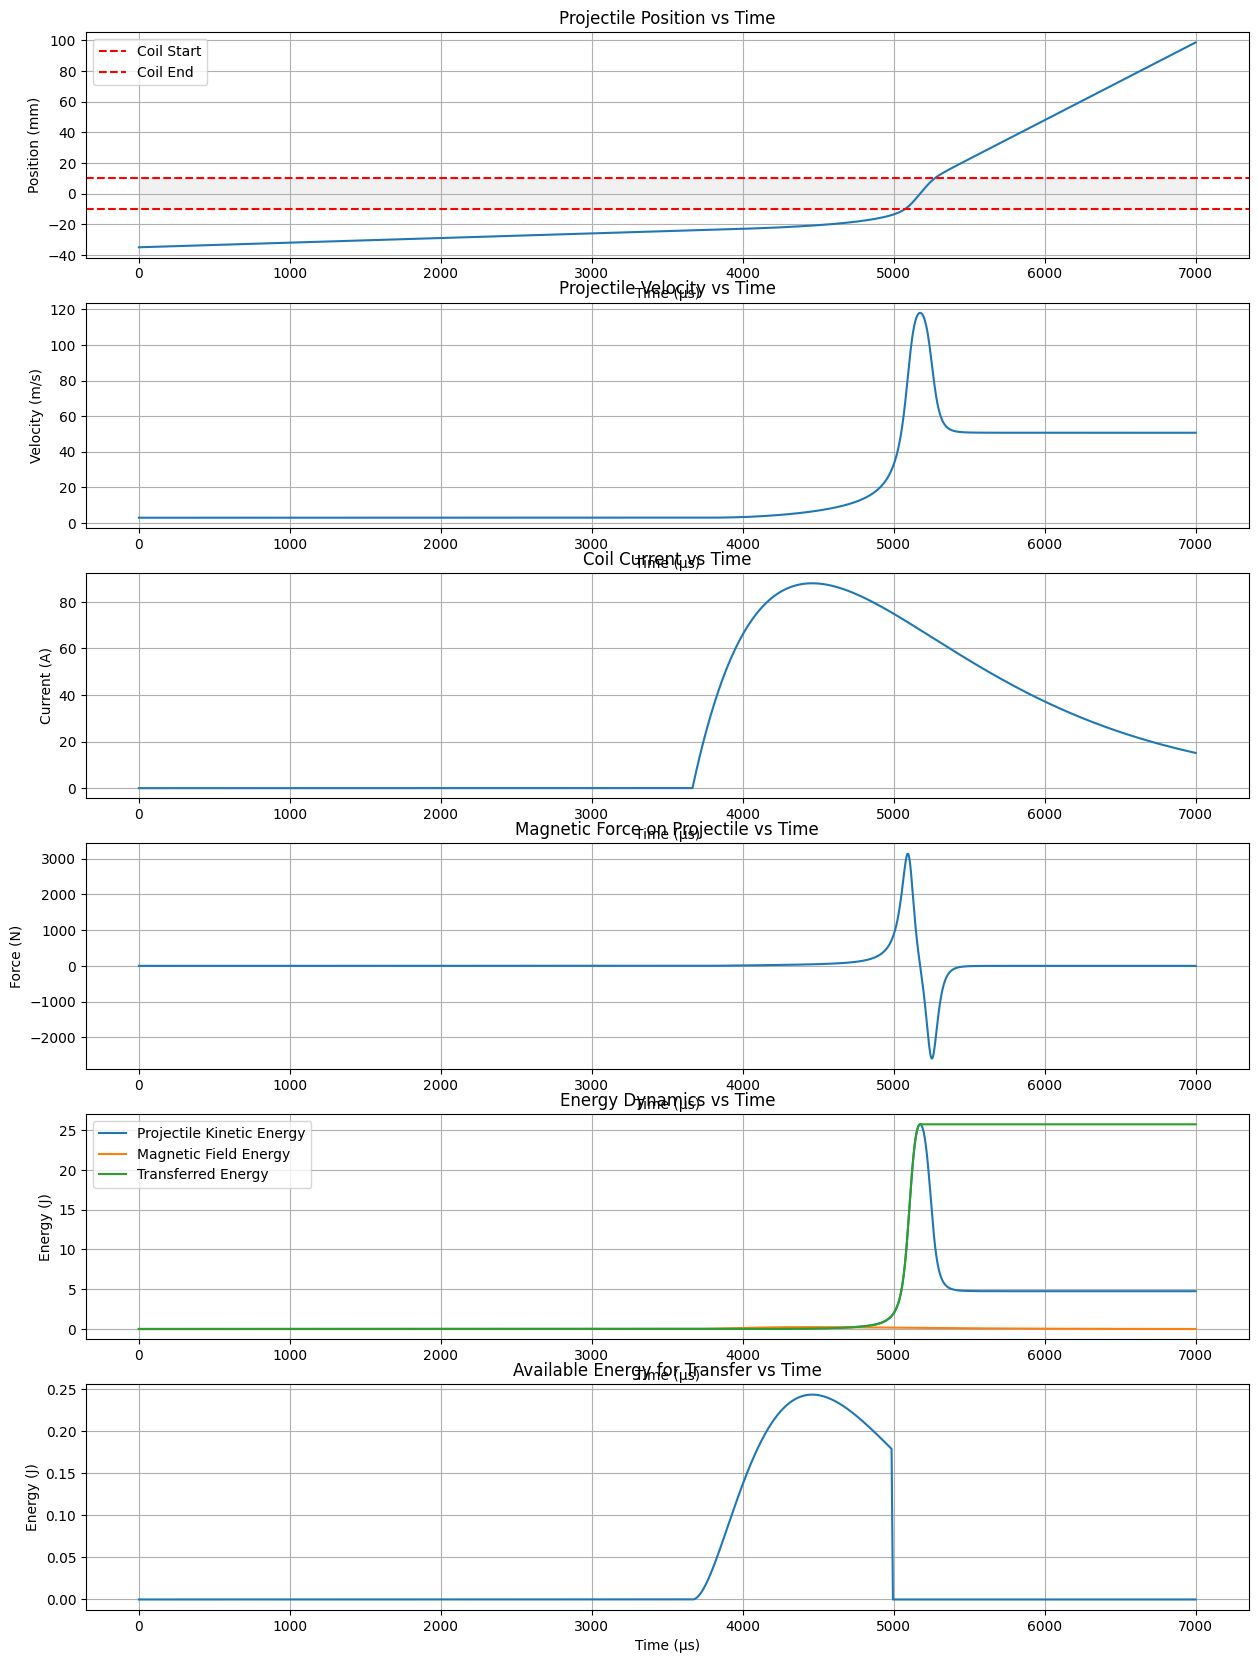

In [133]:
def simulate_projectile_movement(initial_velocity, initial_position, trigger_position, coupling=coupling_factor):
    """
    Simulate projectile movement through the coil with time-dependent magnetic force,
    respecting energy conservation principles.
    
    Parameters:
    initial_velocity (float): Initial velocity of the projectile (m/s)
    initial_position (float): Initial position of projectile center relative to coil center (m)
    trigger_position (float): Position of projectile when capacitor discharge begins (m)
    
    Returns:
    tuple: Time array, position array, velocity array, current array, force array, energy array,
           magnetic energy array, transferred energy array
    """
    # Time parameters
    t_max = 7e-3  # 5 milliseconds simulation time
    dt = 1e-7  # Time step (100 nanoseconds)
    n_steps = int(t_max / dt)
    
    # Initialize arrays
    time_array = np.zeros(n_steps)
    position_array = np.zeros(n_steps)
    velocity_array = np.zeros(n_steps)
    current_array = np.zeros(n_steps)
    force_array = np.zeros(n_steps)
    energy_array = np.zeros(n_steps)
    magnetic_energy_array = np.zeros(n_steps)
    transferred_energy_array = np.zeros(n_steps)
    available_energy_array = np.zeros(n_steps)
    
    # Initial conditions
    time_array[0] = 0
    position_array[0] = initial_position
    velocity_array[0] = initial_velocity
    energy_array[0] = 0.5 * projectile_mass * initial_velocity**2
    
    # Discharge start time (when projectile reaches trigger position)
    discharge_start_time = None
    total_transferred_energy = 0
    clamp_damping_factor = 1

    # Simulation loop
    for i in range(1, n_steps):
        # Current time
        time_array[i] = time_array[i-1] + dt
        
        # Check if trigger position has been reached
        if discharge_start_time is None and position_array[i-1] >= trigger_position:
            discharge_start_time = time_array[i-1]
        
        # Calculate current (if discharge has started)
        if discharge_start_time is not None:
            # Time since discharge started
            t_since_discharge = time_array[i] - discharge_start_time
            current_array[i] = current_at_time(t_since_discharge) * clamp_damping_factor
        else:
            current_array[i] = 0

        if current_array[i] < 0:
            clamp_damping_factor = 1e-3
        
        # Calculate magnetic field energy
        magnetic_energy_array[i] = 0.5 * coil_inductance * current_array[i]**2
        
        # Calculate available energy for transfer (can't exceed what's left in the magnetic field)
        # We need to track how much total energy has been transferred already
        available_energy = max(0, capacitor_energy - total_transferred_energy)
        available_energy = min(available_energy, magnetic_energy_array[i])
        available_energy_array[i] = available_energy
        
        # Calculate force - apply energy conservation constraint
        raw_force = magnetic_force_on_projectile(position_array[i-1], current_array[i]) * coupling_factor
        
        # Limit force to respect energy conservation
        # Maximum work that can be done in this time step
        max_work = available_energy / dt
        
        # Maximum force that respects energy conservation
        max_force = max_work / velocity_array[i-1] if abs(velocity_array[i-1]) > 1e-6 else raw_force
        
        # Use the lesser of the two forces
        force_array[i] = raw_force # min(abs(raw_force), max_force) * (1 if raw_force >= 0 else -1)
        
        # Update velocity using acceleration from force
        acceleration = force_array[i] / projectile_mass
        velocity_array[i] = velocity_array[i-1] + acceleration * dt
        
        # Update position
        position_array[i] = position_array[i-1] + velocity_array[i] * dt
        
        # Calculate energy
        energy_array[i] = 0.5 * projectile_mass * velocity_array[i]**2
        
        # Calculate energy transferred in this time step
        energy_transferred = energy_array[i] - energy_array[i-1]
        if energy_transferred > 0:
            total_transferred_energy += energy_transferred
        
        transferred_energy_array[i] = total_transferred_energy
        
        # Break the loop if projectile is far away from the coil (optimization)
        if abs(position_array[i]) > coil_length * 10:
            # Trim arrays to current size
            time_array = time_array[:i+1]
            position_array = position_array[:i+1]
            velocity_array = velocity_array[:i+1]
            current_array = current_array[:i+1]
            force_array = force_array[:i+1]
            energy_array = energy_array[:i+1]
            magnetic_energy_array = magnetic_energy_array[:i+1]
            transferred_energy_array = transferred_energy_array[:i+1]
            available_energy_array = available_energy_array[:i+1]
            break
    
    return (time_array, position_array, velocity_array, current_array, force_array, 
            energy_array, magnetic_energy_array, transferred_energy_array, available_energy_array)

# Set initial parameters for simulation
initial_velocity = 3.0  # m/s (starting from rest)
initial_position = -coil_length/2  - projectile_length  # m (starting before the coil)
trigger_position = -coil_length/2  - projectile_length*.56 # m (trigger when projectile enters the coil)

# Run simulation
(time_array, position_array, velocity_array, current_array, force_array, 
 energy_array, magnetic_energy_array, transferred_energy_array, available_energy_array) = simulate_projectile_movement(
    initial_velocity, initial_position, trigger_position
)

# Convert time to microseconds for plotting
time_us = time_array * 1e6

# Create subplots for visualization
plt.figure(figsize=(15, 24))

# Plot 1: Position vs Time
plt.subplot(7, 1, 1)
plt.plot(time_us, position_array * 1000)  # Convert to mm
plt.axhline(y=-coil_length/2 * 1000, color='r', linestyle='--', label='Coil Start')
plt.axhline(y=coil_length/2 * 1000, color='r', linestyle='--', label='Coil End')
plt.fill_between(time_us, -coil_length/2 * 1000, coil_length/2 * 1000, color='lightgray', alpha=0.3)
plt.title('Projectile Position vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Position (mm)')
plt.grid(True)
plt.legend()

# Plot 2: Velocity vs Time
plt.subplot(7, 1, 2)
plt.plot(time_us, velocity_array)
plt.title('Projectile Velocity vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

# Plot 3: Current vs Time
plt.subplot(7, 1, 3)
plt.plot(time_us, current_array)
plt.title('Coil Current vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Current (A)')
plt.grid(True)

# Plot 4: Force vs Time
plt.subplot(7, 1, 4)
plt.plot(time_us, force_array)
plt.title('Magnetic Force on Projectile vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Force (N)')
plt.grid(True)

# Plot 5: Energy vs Time
plt.subplot(7, 1, 5)
plt.plot(time_us, energy_array, label='Projectile Kinetic Energy')
plt.plot(time_us, magnetic_energy_array, label='Magnetic Field Energy')
plt.plot(time_us, transferred_energy_array, label='Transferred Energy')
plt.title('Energy Dynamics vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Energy (J)')
plt.grid(True)
plt.legend()

# Plot 6: Available Energy vs Time
plt.subplot(7, 1, 6)
plt.plot(time_us, available_energy_array)
plt.title('Available Energy for Transfer vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Energy (J)')
plt.grid(True)

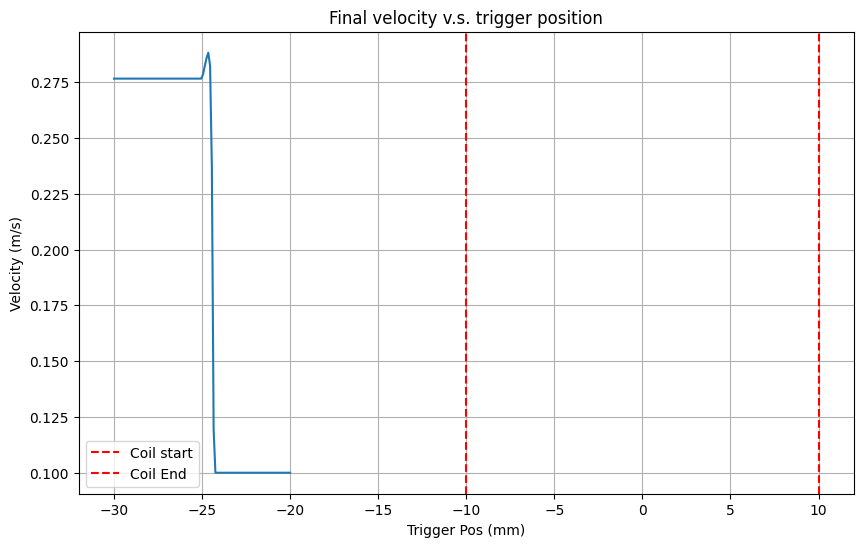

In [132]:
trig_values = np.linspace(-30/1000- projectile_length/2, -20/1000- projectile_length/2, 100)
# trig_values = np.linspace(-coil_length - projectile_length, -coil_length/2, 100)
velocity_values = [0 for t in trig_values]


for i, trigger_pos in enumerate(trig_values):
  (time_array, position_array, velocity_array, current_array, force_array, 
 energy_array, magnetic_energy_array, transferred_energy_array, available_energy_array) = simulate_projectile_movement(
      initial_velocity, initial_position, trigger_pos
  )
  velocity_values[i] = velocity_array[-1]


plt.figure(figsize=(10, 6))
plt.plot(trig_values*1000+1000*projectile_length/2, velocity_values)
plt.title('Final velocity v.s. trigger position')
plt.xlabel('Trigger Pos (mm)')
plt.ylabel('Velocity (m/s)')
plt.axvline(x=-coil_length/2 * 1000, color='r', linestyle='--', label='Coil start')
plt.axvline(x=coil_length/2 * 1000, color='r', linestyle='--', label='Coil End')
plt.grid(True)
plt.legend()
plt.show()  